<a href="https://colab.research.google.com/github/Akkuun/M1_IMAGINE_ML_Project/blob/main/ML_Project_Group_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>Projet Machine Learning</H1>
<H2>HAI817I - 2024/2025</H2>
<H3>Classification d'assertions venant d’X (Twitter) selon leur rapport à la science </H3>



<H1>Groupe 8 </H1>
<br>

Duban Mathis: 22102226

Gonzalez Oropeza Gilles : 21602817

Bernardon Vincent : 22009116

LONGLADE Mickaël : 22105047




<H2> Sujet </H2>

Ce projet s’inscrit dans le contexte de l’apprentissage supervisé, i.e. les données possèdent des
labels. Il vise à trouver les modèles les plus performants pour prédire si des assertions (une
assertion est une proposition que l'on avance et que l'on soutient comme vraie) faites par des
hommes politiques (par exemple) sont vraies ou fausses.




---



<H1>Tables des matières </H1>



*   Installation





## **Installation**


Dans cette partie, nous allons installer toutes les librairies que nous allons avoir besoin pour notre projet.




In [1]:
# Installation des librairies pour le projet
!pip install pandas numpy scipy gensim emoji nltk matplotlib seaborn scikit-learn inflect googletrans==4.0.0-rc1 contractions pyspellchecker

import warnings # Supprime les warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Librairies de manipulation de données (graphique, lecture de données,ect...)
import pandas as pd # Lecture de données
import numpy as np # Array
import seaborn as sns #
import matplotlib.pyplot as plt # Graphique
import sys

# Librairies pour la fonction prepareText
import re # Regular expression
import nltk
from nltk.corpus import stopwords #English stopwords
nltk.download('stopwords') # Téléchargement des stopwords (une seule fois)
from nltk.corpus import wordnet #Mots pour vérifier les suppressions de lettres répétées
nltk.download('wordnet') # Téléchargement de mots existants
import emoji
import inflect # Transformation des chiffres en mots
import re
from googletrans import Translator # Traduction de langues
from nltk.stem import WordNetLemmatizer # Lemmatisation des mots
from nltk.stem import PorterStemmer # Racinanisation des mots
nltk.download('punkt') #Tagetisation des mots
nltk.download('punkt_tab') # Tokenisation des mots
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
from nltk import pos_tag # Tagination des mots
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import unicodedata # Suppresion d'accent
import contractions # Transformation des contractions

#Libraries pour l'entraînement du modèle
from sklearn.feature_extraction.text import TfidfVectorizer # Vectorisation
from sklearn.preprocessing import MaxAbsScaler  # Vectorisation
from spellchecker import SpellChecker # dictionnaire phonétique
from sklearn.feature_extraction.text import CountVectorizer # Topic modelling
from sklearn.decomposition import LatentDirichletAllocation #LDA
from sklearn import preprocessing # Upsampling
from sklearn.preprocessing import StandardScaler # Upsampling
from imblearn.over_sampling import SMOTE # Upsampling
import sklearn
from sklearn.utils import resample #Label encoder
from sklearn.preprocessing import LabelEncoder #Label encoder
from sklearn.tree import DecisionTreeClassifier # Decision TREE classifier
from gensim.models.coherencemodel import CoherenceModel #Coherence model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] # couleur pour les graphiques

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Importation du répertoire de travail sur Google Drive


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
path='/content/gdrive/My Drive/M1_IMAGINE_ML/ML_Project/'
sys.path.append(path)
%cd $path
%pwd

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/M1_IMAGINE_ML/ML_Project


'/content/gdrive/My Drive/M1_IMAGINE_ML/ML_Project'

Récupération des données du dataSet présent sur le répertoire Google Drive en ligne


In [3]:
# Importation des données
df=pd.read_csv('dataSet/data.csv', sep='\t')
# Lecture des 5 premières lignes pour confirmer la bonne récupération des données
display (df.head())

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


Récupération de nos dictionnaires :

In [4]:
# Récupération des monaies
currency_file=pd.read_csv('dataSet/currency_translation.csv')
display (currency_file.head())
# Création d'un objet dictionnaire pour réportorier les objets
currency_dict = dict(zip(currency_file['Currency Symbol'], currency_file['Currency Name']))
# Récupération des abbréviations (Slang)
slang_file=pd.read_csv('dataSet/slang_translation.csv')
display (slang_file.head())
# Création d'un objet dictionnaire pour réportorier les objets
slang_dict = dict(zip(slang_file['Abbreviation'], slang_file['Meaning']))

,Currency Symbol,Currency Name
0,$,dollar
1,€,euro
2,£,pound
3,¥,yen
4,₹,indian rupee


,Abbreviation,Meaning
0,4ao,for adults only
1,a.m,before midday
2,a3,anytime anywhere anyplace
3,aamof,as a matter of fact
4,acct,account


## **Ingénierie des données**

Dans cette partie, on s'interéssèe au pré-traitement des données. Afin que chaque éléments de notre base soit utilisable et pertinent on va nettoyer, normaliser et transformer nos données afin qu'elle soit préparées et optimale pour nos analyses.


<br>

On va ici répertorier tous les éléments qui doivent être traité :

<br>


| Élément            | Exemple                 | Traitement à effectuer | Exemple après traitement |
|--------------------|------------------------|-------------------------|--------------------------|
| Emojis            | 🏀                     | Suppression des émojis ou remplacement par leur signification |  basketball |
| Mention Twitter   | @username               | Remplacement par un Token |  @MENTION |
| Hashtag           | #example                |  Remplacement par un Token | @HASHTAG |
| URL               | http://t.co/XGUfUDoLJB  | Suppression de l'URL | "" |
| Chiffre           | 13                      | Transformation en String | thirdteen |
| Majuscules        | Hello                    | Suppression de la majuscule | hello |
| Ponctuation       | !                        | Suppression de la ponctuation | "" |
| Mots répétés      | cool cool cool         | Normalisation en une seule occurrence | cool |
| Lettres répétées  | that's greeeeeeeat!        | Réduction des répétitions excessives | that's great! |
| Abréviations      | ngl, fr | Remplacement par la version complète | not gonna lie, for real |
| Stopwords (déterminants)         | the, and, a  | Suppression si non pertinent | "" |
| Slang (Argot)     | gonna, dunno, wanna           | Remplacement par des mots standards | going to, do not know, want to |
| Langue étrangère  | bonjour, gracias          | Détection et traduction éventuelle | hello, thank you |
| Caractères spéciaux | §, $, ^                | Suppression des charactères | "" |
| Expressions courantes | btw, lol    | Remplacement par la version complète | by the way, laughing out loud|
| Négation mal formatée | ain't, dunno          | Correction grammaticale | am not, do not know |
| Émojis en Unicode | `\U0001F60D` (😍)      | Conversion en texte lisible | smiling_face_with_hearteyes |
| Symboles de devises |    10\$, 10€               | Normalisation (ex: "10 euros") | 10 dollars, 10 euros |
| Accents |    cliché              | Normalisation | cliche |
| Heures |    10AM, 13:30              | Remplacement par un token | @TIME  |
| Numéro de téléphone |  +339208373  | Remplacement par un token | @PHONENUMBER  |
| Expression flottante |  14,34 10,000  | Conversion en texte lisible | fourteen thirty-four,  ten thousand |







On implémente ici nos fonctions que nous allons utiliser par la suite :

In [5]:
#Fonction permettant de supprimer les numéros de téléphones
def removeSpecialCharacters(word, keepTokens):
    # Replace '+' followed by digits (potential phone numbers) with 'PHONE_NUMBER'
    if keepTokens:
        word = re.sub(r'\+\d+', 'TOKENPHONENUMBER', word)
    else:
        word = re.sub(r'\+\d+', '', word)

    # remove / between numbers : 10/10 -> 10 out of 10
    word = re.sub(r'(\d+)/(\d+)', r'\1 out of \2', word)

    # Replace time expressions in HH:MM format
    if keepTokens:
        word = re.sub(r'\b\d{1,2}:\d{2}\b', 'TOKENTIME', word)
    else:
        word = re.sub(r'\b\d{1,2}:\d{2}\b', '', word)

    # Replace numbers followed by 'k' with their full value (e.g., 41916514k → 41916514000 ,  or 5.5k -> 5500)
    word = re.sub(r'(\d+)k\b', lambda m: str(int(m.group(1)) * 1000), word)
    return word

#Fonction permet de supprmimer les répétitions succésive de lettres (cas particulier rencontré)
def fixRepeat(word):
    # Reduce excessive repetition to exactly 2 occurrences
    repeat_regexp = re.compile(r'(\w*)(\w)\2{2,}(\w*)')
    repl = r'\1\2\2\3'

    if wordnet.synsets(word):
        return word

    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:
        return fixRepeat(repl_word)

    # Try all combinations of removing one duplicate letter at a time
    candidates = set()
    for i in range(len(repl_word) - 1):
        if repl_word[i] == repl_word[i + 1]:
            candidates.add(repl_word[:i] + repl_word[i+1:])

    # Check if any of the candidates is a valid word
    for candidate in candidates:
        if wordnet.synsets(candidate):
            return candidate

    # No valid word is found, return the single-letter version
    single_letter_version = re.sub(r'(.)\1', r'\1', repl_word)
    return single_letter_version

# Fonction permettant de supprimer les accents
def remove_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

On créer donc notre fonction **prepareText** permettant de preparer nos données brutes afin de les reformater correctement :

In [6]:
stop_words_set = set(stopwords.words('english'))
translator = Translator() # initialisation du traducteur
lemmatizer = WordNetLemmatizer() # initialisation du lematiseur
stemmer = PorterStemmer() # initialisation du taggeisteur
tokens = {"MENTION", "HASHTAG", "TIME", "PHONENUMBER"} # liste de nos token à identifier

# Fonction permettant de préparer la chaîne de charactères passé en paramètre
def prepareText(text, keepTokens: bool = True, keepEmojis: bool = True, numbersAsTokens: bool = False, translate = True):
    """
    Prépare la chaîne de caractère passée en paramètre

    Parameters
    ----------
    text : str
        La chaîne de caractères
    keepTokens : bool, optional
        True si on doit garder les token, False si on doit les supprimer (defaut : True)
    keepEmojis : bool, optional
        True si on doit garder les emojis, False si on doit les supprimer (defaut : True)
    numbersAsTokens : bool, optional
        True si on doit transformer les chiffres en token, False si on doit les supprimer (defaut : False)
         Ce token n'est pas supprimé si keepToken vaut False
    translate : bool, optional
        True si on doit traduire le texte en anglais, False si on ne le fait pas (defaut : True)

    Returns
    -------
    str
        La chaîne de caractère préparée
    """
    #Majuscule, suppression
    data = str(text).lower()

    #Suppresion d'accent
    data = remove_accents(data)

    #Contraction, on corrige
    data = contractions.fix(data)

    #Emoji, transformation en String
    if (keepEmojis):
        data = emoji.demojize(data)
    else:
        data = emoji.replace_emoji(data, replace='')

    #Mention Twitter, transformation en Token
    if (keepTokens):
        data = re.sub(r'@\w+', 'TOKENMENTION', data)
    else:
        data = re.sub(r'@\w+', '', data)

    #Hashtag, transformation en Token
    if (keepTokens):
        data = re.sub(r'#\w+', 'TOKENHASHTAG', data)
    else:
        data = re.sub(r'#\w+', '', data)

    #URL, on supprime
    data = re.sub(r'https?://\S+|www\.\S+', '', data)


    #Devise, remplacement par sa chaîne de charactere
    for symbol, name in currency_dict.items():
        data = re.sub(rf'(\d+){re.escape(symbol)}', r'\1 ' + name, data)


    #Special caracters that requires more attention than just remove
    data = removeSpecialCharacters(data, keepTokens)

    #Keep rating expressions (ex : 10/10)
    rating_expressions = {}

    def replace_match(match):
        key = f"RATING_{len(rating_expressions)}"  # Unique placeholder
        rating_expressions[key] = match.group(0)   # Store full match
        return key

    # Replace rating expressions with placeholders
    data = re.sub(r'(\d+|ten|nine|eight|seven|six|five|four|three|two|one) out of (\d+|ten|nine|eight|seven|six|five|four|three|two|one)', replace_match, data)


    #Stopwords, suppression
    data = ' '.join([word for word in data.split() if word not in stop_words_set])

    # Restore full rating expressions
    for key, value in rating_expressions.items():
        data = data.replace(key, value)

    #Ponctuation & charactères spéciaux, suppression
    data = re.sub(r'[^\w\s]', '', data)

    #Chiffre, transformation en String
    if (numbersAsTokens):
        words = data.split()
        data = ' '.join(["number" if word.isdigit() else word for word in words])
    else:
        words = data.split()
        data = ' '.join([inflect.engine().number_to_words(word) if word.isdigit() else word for word in words])



    #Heures, transformation en token
    if keepTokens:
        data = re.sub(r'\b(\d{1,2}([:h]\d{2})?\s*(am|pm)?)\b', 'TOKENTIME', data)
    else:
        data = re.sub(r'\b(\d{1,2}([:h]\d{2})?\s*(am|pm)?)\b', '', data)


    #Abréviation (Slang)
    data = ' '.join([slang_dict.get(word, word) for word in data.split()])

    #Mots répétés
    data = re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', data)
    #Lettres répétés
    data = ' '.join([fixRepeat(word) for word in data.split()])

    #remplacer TOKEN par @TOKENxxxx correspondant
    if (keepTokens):
        for token in tokens:
            data = re.sub(rf'TOKEN{token}', f'@{token}', data)

    #Traduction du tweet
    if translate:
        try:
            data = translator.translate(data, dest='en').text
        except Exception as e:
            pass

    return data

Exemple du passage de notre fonction


In [7]:
#URL
display("http://t.co/XGUfUDoLJB")
display(prepareText("http://t.co/XGUfUDoLJB"))
print("\n")
#Chiffre
display("3")
display(prepareText("3"))
print("\n")
#Majuscule
display("Hello")
display(prepareText("Hello"))
print("\n")
#Ponctuation
display("Hello!")
display(prepareText("Hello!"))
print("\n")
#Abréviation
display("lol")
display(prepareText("lol"))
print("\n")
#StepWord
display("After planning the project, she carefully researched each step, ensuring the execution was smooth and timely")
display(prepareText("After planning the project, she carefully researched each step, ensuring the execution was smooth and timely"))
print("\n")
#Emojis
display("😍")
display("keepEmojis=True : " + prepareText("😍", keepEmojis=True))
display("keepEmojis=False : " + prepareText("😍", keepEmojis=False))
print("\n")
#Traductions (dernière étape)
display("我今天去超市买了一些水果")
display("translate=True : " + prepareText("我今天去超市买了一些水果", translate=True))
display("translate=False : " + prepareText("我今天去超市买了一些水果", translate=False))
print("\n")
#Mention Twitter
display("as @username said it's bad !")
display("keepTokens=True : " + prepareText("as @username said it's bad !", keepTokens=True))
display("keepTokens=False : " + prepareText("as @username said it's bad !", keepTokens=False))
print("\n")
#Hashtag
display("I went to the theater to see Dune 2 #Dune")
display(prepareText("I went to the theater to see Dune 2 #Dune"))
print("\n")
#Charactères spéciaux
display("§$£")
display(prepareText("§$£"))
print("\n")
#Devices
display("10$ 10£ 10€")
display(prepareText("10$ 10£ 10€"))
print("\n")
#Mot répétés
display("Cool Cool Cool Cool Hot Hot Hot")
display(prepareText("Cool Cool Cool Cool Hot Hot Hot"))
print("\n")
#Lettres répétées
display("Steaaaaaaaak tendeeeeers beeeeer goooooose   threeeeeeee woooooooooood aggggggggressive")
display(prepareText("Steaaaaaaaak tendeeeeers beeeeer goooooose   threeeeeeee woooooooooood aggggggggressive"))
print("\n")
#Accent
display("cliché")
display(prepareText("cliché"))
print("\n")
#Heures
display("10AM computer 10:30 potatoes 10h30")
display(prepareText("10AM computer 10:30 potatoes 10h30"))
print("\n")
#Numéro de téléphone
display("+33123456789")
display(prepareText("+33123456789"))
print("\n")
#Expression flottante
display("14,34 10,000")
display("numbersAsTokens=True : " + prepareText("14,34 10,000", numbersAsTokens=True))
display("numbersAsTokens=True : " + prepareText("14,34 10,000", numbersAsTokens=False))
print("\n")
# 10/10
display("10/10")
display(prepareText("10/10"))
print("\n")
#Charactères spéciaux (nuémro de téléphone, x/x , 10,0000)
display("N. Lutz ")
display(prepareText("N. Lutz"))
print("\n")

'http://t.co/XGUfUDoLJB'

''

'3'

'three'

'Hello'

'hello'

'Hello!'

'hello'

'lol'

'laughing out loud'

'After planning the project, she carefully researched each step, ensuring the execution was smooth and timely'

'planning project carefully researched step ensuring execution smooth timely'

'😍'

'keepEmojis=True : smiling_face_with_hearteyes'

'keepEmojis=False : '

'我今天去超市买了一些水果'

'translate=True : I went to the supermarket today to buy some fruit'

'translate=False : 我今天去超市买了一些水果'

"as @username said it's bad !"

'keepTokens=True : @MENTION said bad'

'keepTokens=False : said bad'

'I went to the theater to see Dune 2 #Dune'

'went theater see dune two @HASHTAG'

'§$£'

''

'10$ 10£ 10€'

'ten dollar ten pound ten euro'

'Cool Cool Cool Cool Hot Hot Hot'

'cool hot'

'Steaaaaaaaak tendeeeeers beeeeer goooooose   threeeeeeee woooooooooood aggggggggressive'

'steak tenders beer goose three wood aggressive'

'cliché'

'cliche'

'10AM computer 10:30 potatoes 10h30'

'@TIME computer @TIME potatoes @TIME'

'+33123456789'

'@PHONENUMBER'

'14,34 10,000'

'numbersAsTokens=True : number'

'numbersAsTokens=True : one thousand, four hundred and thirty-four ten thousand'

'10/10'

'ten out of ten'

'N. Lutz '

'n lutz'

On créé une copie de notre set de données de base et on applique notre fonction sur tout nos tweets /!\ cette cellule prend un temps de calcul conséquent car elle créer une copie du CSV avec les données toutes formattées.

In [8]:
# Création copie données
dataPrepared =df.copy()
# Application de notre fonction de preparation sur dataPrepared
dataPrepared['text'] = dataPrepared['text'].apply(prepareText)

On supprime toutes les lignes contenant un tweet vide :

In [9]:
# Suppression de toutes les lignes vides
dataPrepared = dataPrepared[dataPrepared['text'] != '']

# Afficher le nombre de ligne ayant un tweet vide
print("Nombre de lignes contenant un tweet vide : ", len(df[df['text'] == '']))

# Afficher
print("5 premières lignes du dataset :")
display(dataPrepared.head())


Nombre de lignes contenant un tweet vide :  0
5 premières lignes du dataset :


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knees bit sore guess sign recent treadmiling w...,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonalds breakfast stop gym basketbalflexed_b...,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain dangers...,1,1.0,0.0,0.0
3,3,322694830620807168,couchlock highs lead sleeping couch got stop shit,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problems bipolar di...,1,1.0,0.0,0.0


Une fois notre premier traitement effectué on va effecter la dernière partie des traitements des données brutes la lemmatisation, racinisation et tagination. Ces étapes permettent d'affiner le texte pour que chaque mot soit réduit à sa forme de base, ce qui est essentiel pour de nombreuses applications de traitement de texte, comme la recherche d'informations ou l'analyse de sentiments.

Voici les étapes que l'on va faire après le formatage :

Lemmatisation : Cette technique consiste à réduire un mot à sa forme canonique (ou lemmé), c'est-à-dire à la forme sous laquelle il apparaît dans le dictionnaire. Exemple better deviendra good.

Racinisation : Cette méthode consiste à réduire un mot à sa racine, c'est-à-dire à enlever les suffixes (ou préfixes) pour obtenir une forme simplifiée du mot. Cela permet de mieux traiter les variations de mot comme runner qui devriendra run.

Tagination (ou étiquetage de parties du discours) : Cette technique consiste à identifier et à étiqueter chaque mot d'un texte en fonction de sa catégorie grammaticale (nom, verbe, adjectif, etc.)

<br>

On va commencer par appliquer une tokenisation et une taggenisation sur chacun de nos tweets. Pour cela on va définir 2 fonctions :

In [10]:
#Fonction permettant de récupérer le bon tag du mot passé en paramètre
def get_wordnet_pos(word):
    if word.startswith('J'):
        return wordnet.ADJ
    elif word.startswith('V'):
        return wordnet.VERB
    elif word.startswith('N'):
        return wordnet.NOUN
    elif word.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Fonction qui applique la tokenisation et une taggenisation sur une phrase passée en paramètre
def lemmatize_taggenize_sentence(sentence):
    tokens = word_tokenize(sentence) # Tokenisation du texte
    tagged_tokens = pos_tag(tokens) # Étiquetage des mots (POS tagging)
    lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens]
    return " ".join(lemmatized)



Essayons notre fonction :

In [11]:
print(dataPrepared['text'][0])
print(lemmatize_taggenize_sentence(dataPrepared['text'][0]))

knees bit sore guess sign recent treadmiling working
knee bite sore guess sign recent treadmiling work


On applique alors notre fonction sur nos données préparées :

In [12]:
dataPrepared['text'].apply(lemmatize_taggenize_sentence)

,text
0,knee bite sore guess sign recent treadmiling work
1,mcdonalds breakfast stop gym basketbalflexed_b...
2,gynecologist cancer experience explain danger ...
3,couchlock high lead sleep couch get stop shit
4,daily routine help prevent problem bipolar dis...
...,...
1135,@ MENTION sorry one out of four million dead c...
1136,dear @ HASHTAG applicant kindly download enrol...
1137,uber support team email address
1138,house pass bill increase stimulus check two th...


On va ajouter dans notre DataFrame un attribut contenant les tweets correctement traités en appliquant les opérations suivantes :

  - Normalisation du texte : suppression des variations morphologiques.

  -Réduction de la dimensionnalité : un même concept est représenté par un seul mot.
  
  -Amélioration des performances des modèles : les algorithmes de Machine Learning comprennent mieux les relations entre les mots.

  <br>

  La partie subtile c'est que ce genre de traitement peuvent influencer complétement les mots post-traitement. Par exemple unhappiness doit devenir unhappy, pour éviter ce genre d'erreur on doit appliquer une dernière transformation :

In [13]:
#Fonction qui permet de ne pas perdre le sens d'un mot traité (i.e unhap)
def refine_stem_lemmatize(token, tag):
    try:
        # Ignorer les mots contenant des underscores, chiffres ou caractères spéciaux

        # Racinisation
        stemmed = stemmer.stem(token)

        # Vérification du préfixe "un"
        if stemmed.startswith("un") and len(stemmed) > 2:  # Vérifie que "un" n'est pas seul
            root = stemmed[2:]  # Retire le préfixe "un"
            if wordnet.synsets(root):  # Vérifie si la racine sans "un" est valide dans WordNet
                return f"not {root}"

        # Vérification de validité du mot racinisé
        if not wordnet.synsets(stemmed):
            stemmed = token  # Si le mot racinisé est incompréhensible, garde l'original

        # Lemmatisation
        lemmatized = lemmatizer.lemmatize(stemmed, get_wordnet_pos(tag))
        return lemmatized
    except Exception as e:
        # Afficher le mot problématique et son erreur
        print(f"Erreur avec le mot : '{token}' - Exception : {e}")
        raise e  # Propager l'exception pour un traitement éventuel



#Fonction qui ajoute dans le dataSet un colonne contenant le texte traité
def process_text_column(text):

    # Tokenisation et traitement
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    processed_tokens = [refine_stem_lemmatize(token, tag) for token, tag in tagged_tokens]
    return " ".join(processed_tokens)


# Créer une colonne vide pour stocker les textes transformés
dataPrepared['processed_text'] = ""

# Boucle for avec iterrows
for index, row in dataPrepared.iterrows():
    text = row['text']  # Récupérer le texte original

    if pd.notnull(text) and text.strip() != "":  # Vérifier que le texte est valide
        try:
            # Appliquer la fonction process_text_column
            dataPrepared.at[index, 'processed_text'] = process_text_column(text)
        except Exception as e:
            print(f"Erreur à l'index {index} avec le texte : {text}")
            print(f"Exception : {e}")
            dataPrepared.at[index, 'processed_text'] = ""  # Insérer une chaîne vide en cas d'erreur
    else:
        dataPrepared.at[index, 'processed_text'] = ""  # Gérer les textes nuls ou vides


On teste notre fonction de traitement final :

In [14]:
text = "The runners were running faster than the dogs unhappiness displacement inflexibility irresponsible kindness impossible"
tokens = word_tokenize(text)
tagged_tokens = pos_tag(tokens)
stemmed_then_lemmatized = [refine_stem_lemmatize(token, tag) for token, tag in tagged_tokens]
print("racinetisation puis lemmatization : ")
print(" ".join(stemmed_then_lemmatized))
print("\n")

stemmed_tokens = [stemmer.stem(token) for token in tokens]
lemmatized = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens]
print("racinetisation : ")
print(" ".join(stemmed_tokens))
print("\n")
print("lemmatization : ")
print(" ".join(lemmatized))

racinetisation puis lemmatization : 
The runner be run faster than the dog unhappiness displacement inflexibility irresponsible kind impossible


racinetisation : 
the runner were run faster than the dog unhappi displac inflex irrespons kind imposs


lemmatization : 
The runner be run faster than the dog unhappiness displacement inflexibility irresponsible kindness impossible


On remplace dans notre dataSet la colonne processed_text contenant le texte filtré et traité par text afin d'obtenir qu'un seul attribut :

In [15]:
#Ajout de l'attribut processed_text sur chaque ligne de notre dataSet
dataPrepared['text'] = dataPrepared['processed_text']
#Suppression de l'attribut processed_text
dataPrepared = dataPrepared.drop(columns=['processed_text'])

# Sauvegarde des données dans un CSV
dataPrepared.to_csv('dataSet/dataPrepared.csv', index=False)

#Affichage des 5 premières lignes
display(dataPrepared.head())


,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,knee bite sore guess sign recent treadmiling work,0,0.0,0.0,0.0
1,1,319090866545385472,mcdonalds breakfast stop gym basketbalflexed_b...,0,0.0,0.0,0.0
2,2,322030931022065664,gynecologist cancer experience explain danger ...,1,1.0,0.0,0.0
3,3,322694830620807168,couchlock high lead sleep couch get stop shit,1,1.0,0.0,0.0
4,4,328524426658328576,daily routine help prevent problem bipolar dis...,1,1.0,0.0,0.0


## **Vectorisation via TF-IDF**

Dans cette partie, on souhaite continuer notre travail visant à préparer nos données pour les envoyer aux algortihme d'apprentisage automatique. Pour cela, on va effectuer une vectorisation via la méthode TF-IDF.

<br>

Le principe de la vectorisation est de convertir des données textuelles en une représentation numériques. Cela va permettre aux algorithmes d'apprentissage automatique de comprendre et de traiter le langage humain à partir de nos données préparées.

<br>

Dans notre cas, on a décidé d'utiliser les n-grammes (séquence de n mot répétées), cela va nous permettre de récupérer les relations entre les mots et ainsi détecter les mots qui pourrait potentiellement nous conduire vers une fake news ou nous indiquer les mots démontrant qu'un tweet est scientifique.


In [16]:
#recuperation des data préparés
dataPrepared = pd.read_csv('dataSet/dataPrepared.csv')

# Configuration du vecteur TF-IDF avec des n-grammes
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)

# Ajustement TF-IDF
vectorizedText = vectorizer.fit_transform(dataPrepared['text'])

#
scaler = MaxAbsScaler()
scaled = scaler.fit_transform(vectorizedText)

# Conversion en un DataFrame
vectorized_df = pd.DataFrame(data=scaled.toarray(), columns=vectorizer.get_feature_names_out())

# Display sample
display(vectorized_df)



,abuse,account,act,action,activity,actual,address,affect,again,age,...,world,would,write,wrong,year,yes,yet,york,you,yous
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,0.0,0.0,0.0,0.0,0.0,0.565774,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.460315
1135,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1136,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1137,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


##**Topic Modelling via LDA**

<br>

Une fois nos données vectorisées et compréhensives pour la machine, nous allons appliquer le principe de *Topic Modelling*.

<br>


Le topic modelling est une technique d'apprentissage automatique non supervisée qui identifie et extrait des thèmes ou des sujets latents à partir d'un ensemble de documents textuels (dans notre cas notre ensemble de tweet). Le but de cette étape est d'aider notre futur modèle à labelliser ses donénes tout en identifiant les sujets principaux.

<br>

Dans notre cas, nous utilisons LDA (Latent Dirichlet Allocation), cette technique cherche à découvrir des thématiques cachées (topics) dans un ensemble de documents. On va appliquer le LDA affin d'identifier les topics de chaque tweets et les insérers dans un attributs nommé 'Topic'.

<br>

Afin d'obtenir des topics pertinent, il faut faire attention à la répartition de ces derniers, si nous avons un topic trop dominant (ex:30%), cela va écraser la représentation des autres topics. On va alors jouer sur le nombre de topics à représenter afin d'obtenir une réparition plus partagées. De plus nous devons faire attention que chaque topic ai du sens. Le but de cette étape est purement statistique.

'Visualisation des recurrences et de la répartition des topics :'

,Représentation (%),Occurence
Topic,,
7,0.140474,160
9,0.093942,107
10,0.081651,93
5,0.076383,87
3,0.071993,82
13,0.070237,80
1,0.066725,76
0,0.063213,72
12,0.062335,71


'Affichage des topics principaux représenté dans nos tweets :'

'Topic 1: people, stop, world, love, cause, plea, chang, take, news, like'

'Topic 2: hashtag, new, mention, stop, support, high, prevent, get, ask, would'

'Topic 3: and, hundred, hundred and, five, three, one, eight, five hundred, seven, fifty'

'Topic 4: lead, science, mention, job, work, hashtag, woman, new, climate, pain'

'Topic 5: good, hashtag, look, mention, right, give, promote, think, stop, god'

'Topic 6: hashtag, increase, cancer, mention, stop, brain, come, could, trump, police'

'Topic 7: one, free, war, mean, not, issue, sleep, day, increase, story'

'Topic 8: hashtag, mention, support, mention hashtag, support hashtag, hashtag mention, retwet, nation, eye, process'

'Topic 9: mention, not, stop, game, it, time, report, via, put, people'

'Topic 10: stop, mention, get, need, hashtag, time, go, mention stop, back, thank'

'Topic 11: mention, support, hashtag, research, help, via mention, via, video, four, school'

'Topic 12: mention, find, report, associate, use, death, study, two, read, end'

'Topic 13: hashtag, mention, stop, report, call, support, animal, law, start, men'

'Topic 14: and, thousand, two, hundred, one, hundred and, thousand and, two thousand, twenty, one thousand'

'Topic 15: mention, report, patient, must, though, support, people, way, good, technology'

'Visualisation de la répartition des topics via un graph normalisé :'

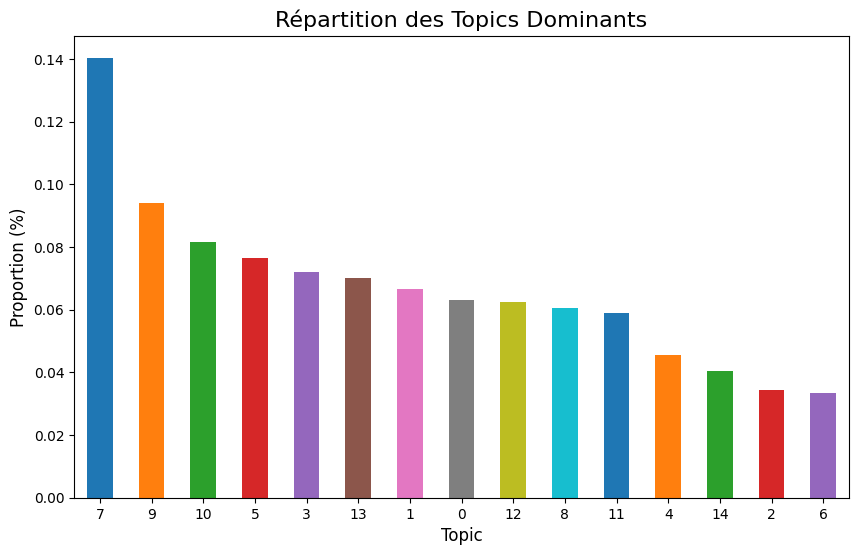

In [21]:
#Fonction permettant d'afficher les mots les plus courant d'un topic en question
def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        display(f"Topic {topic_idx+1}: {', '.join(top_words)}")



# Transformer TF-IDF en une Matrice Exploitable par LDA
count_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=5, max_df=0.9)
count_matrix = count_vectorizer.fit_transform(dataPrepared['text'])



# Configuration du modèle LDA pour l'appliquer
n_topics = 15  # Nombre de topics à identifier ( variable à ajuster pour avoir +/- de topic majeur à identfier)

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

# Préparer les données tokenisées
tokenized_texts = [text.split() for text in dataPrepared['text']]

# Créer un dictionnaire et un corpus
# surment des variable deja existant juste pas trouver dans le code
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
# Entraîner un modèle LDA
lda_model_gensim = LdaModel(corpus=corpus, num_topics=n_topics, id2word=dictionary, passes=10, random_state=42)


lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)

# Entraînement du modèle
lda_topics = lda_model.fit_transform(count_matrix)


# Obtenir les mots les plus représentatifs de chaque topic
feature_names = count_vectorizer.get_feature_names_out()



# Associer chaque tweet à son topic dominant
topic_assignments = np.argmax(lda_topics, axis=1)

# Ajouter au DataFrame
dataPrepared['Topic'] = topic_assignments

# Afficher pour chaque répartition son nombre d'itération et son occurence normalisé dans le même tableau
topic_counts = dataPrepared['Topic'].value_counts(normalize=True)

# Convertir les occurrences en pourcentage
topic_counts_percent = dataPrepared['Topic'].value_counts()

# Créer un tableau avec le nombre d'occurrences et les pourcentages
topic_stats = pd.DataFrame({
    'Représentation (%)': topic_counts,
    'Occurence': topic_counts_percent
})

display("Visualisation des recurrences et de la répartition des topics :")

# Afficher le tableau
display(topic_stats)


display("Affichage des topics principaux représenté dans nos tweets :")
# Afficher les topics principaux représenté 1,3,0,2,4
print_top_words(lda_model, feature_names, n_top_words=10)


display("Visualisation de la répartition des topics via un graph normalisé :")
# Visualisation de la répartition des topics via un graph normalisé
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar', color=colors)
plt.title('Répartition des Topics Dominants', fontsize=16)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=0)
plt.show()





On observe que nous avons des topics ayant une réparition +/- équivalente, ce qui signifie que ces 7 topics sont à peu près représentés de la même manière dans nos tweets.


Evaluons la cohérence de nos topics /!\ à finir


In [24]:
#Evaluons la cohérence de nos topics
coherence_model = CoherenceModel(model=lda_model_gensim, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Score de cohérence des topics : {coherence_score}")

Score de cohérence des topics : 0.3672056019463689


Visualisation du nuage des mots de chaque topics


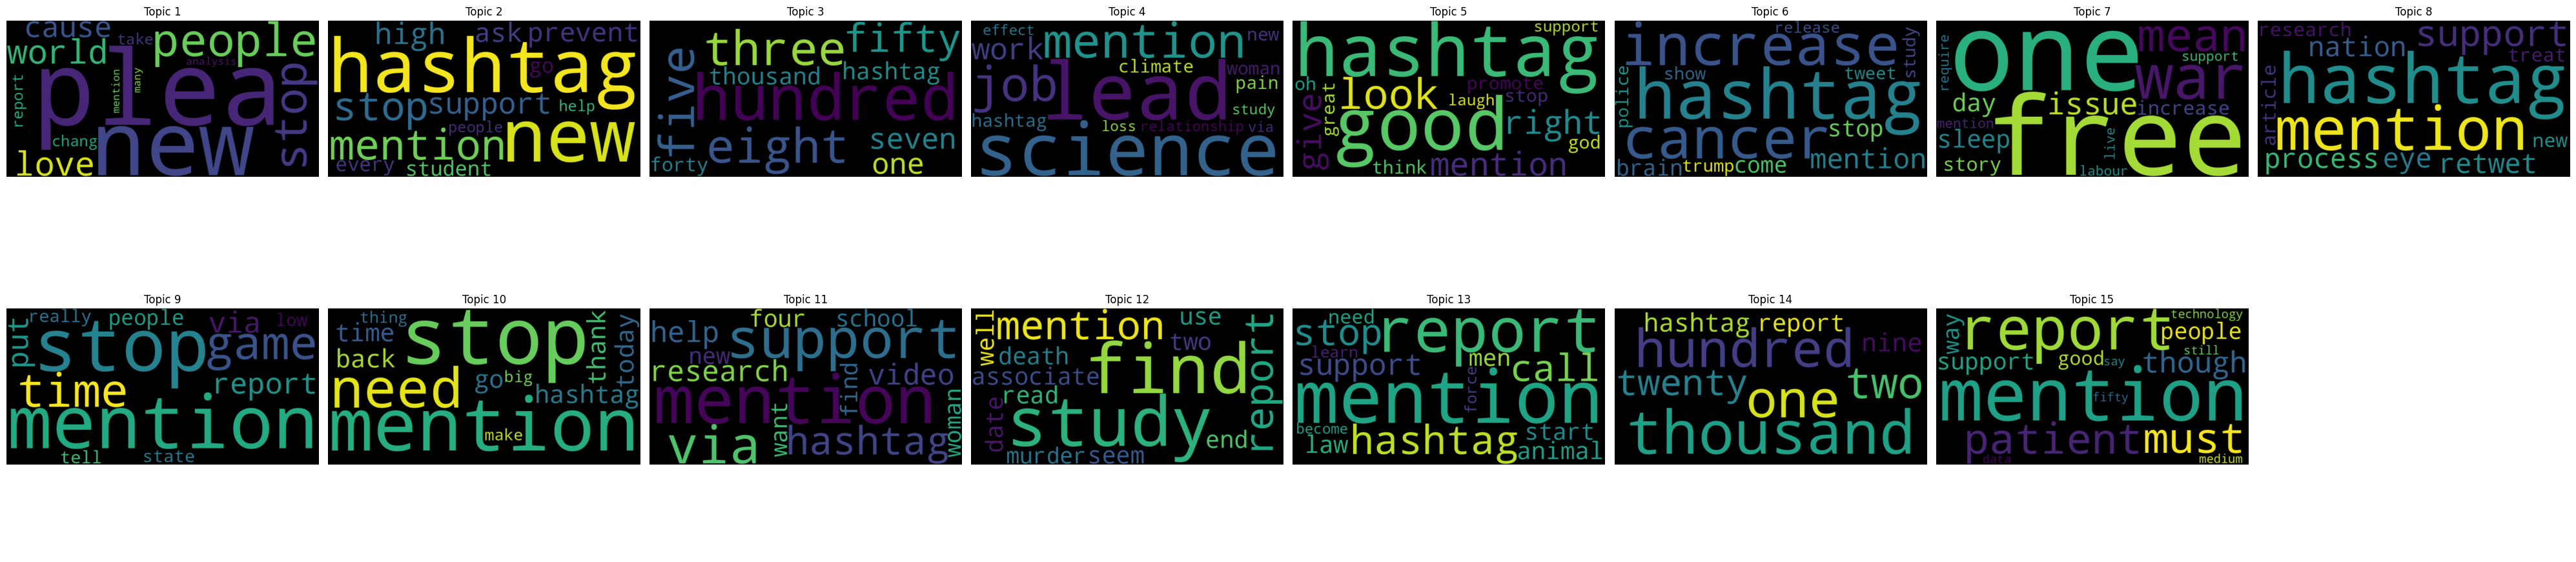

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

n_topics = len(lda_model.components_)


n_rows = 2
n_cols = (n_topics // n_rows) + (n_topics % n_rows > 0)


fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()
# Boucle sur chaque topic pour créer le nuage de mots
for topic_idx, topic in enumerate(lda_model.components_):
    # Générer le nuage de mots pour chaque topic
    wordcloud = WordCloud(width=800, height=400).generate(" ".join([feature_names[i] for i in topic.argsort()[:-15 - 1:-1]]))
    # Afficher le nuage de mots dans le sous-graphe approprié
    axes[topic_idx].imshow(wordcloud, interpolation="bilinear")
    axes[topic_idx].axis("off")  # Retirer les axes
    axes[topic_idx].set_title(f"Topic {topic_idx + 1}")
for i in range(n_topics, len(axes)):
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## **Classification**

Le but de la classification est de permettre de déterminer le contexte de nos tweets en fonction de leurs caractéristiques.

<br>

Pour obtenir les meuilleurs résultats possibles, nous allons pour établir 4 méthodes de classification :

<br>


-Decision Tree

-Naïve Bayes

-SVC (Support Vector Clustering)

-KNN (k-nearest neighbors)

<br>

Puis nous allons les tester sur 3 taches de classification :

- {SCIENTIFIQUE} vs. {NON SCIENTIFIQUE} (2 classes)
- {CLAIM, REF} vs. {CONTEXT} (deux classes)
-{CLAIM} vs. {REF} vs. {CONTEXT} (trois classes)

Une fois ce travail réalisé, nous pourrons évaluer les performaces de chaque classifieur via plusieurs métriques différentes.


Nous afficherons nos résultats via des courbes définir ci-dessous :

In [25]:
#Fonction d'affichage des courbes
def plot_curves_confusion(confusion_matrix, class_names):
    plt.figure(1, figsize=(16, 6))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1, top=0.9, wspace=0.25, hspace=0)

    # Matrice de confusion
    plt.subplot(1, 3, 3)
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted', fontsize=12)
    plt.title("Confusion matrix")
    plt.ylabel('True', fontsize=12)
    plt.show()


def plot_curves(scores):
    plt.figure(1, figsize=(16, 6))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1, top=0.9, wspace=0.25, hspace=0)

    # Plot loss
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(scores, color='blue')
    plt.ylabel('Loss')
    plt.xlabel('Fold')

    # Plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(1 - scores, color='red')
    plt.ylabel('Error Rate')
    plt.xlabel('Fold')

    plt.show()

def plot_curves_results(naive_scores, svc_scores, decision_scores, knn_scores):
  classifiers = ['Naive Bayes', 'SVC', 'Decision Tree', 'KNN']

  fold_scores = [naive_scores, svc_scores, decision_scores, knn_scores]

  # Scores moyens
  plt.figure(figsize=(8, 5))
  mean_scores = [score.mean() for score in fold_scores]
  plt.bar(classifiers, mean_scores, color=['blue', 'orange', 'green', 'red'])
  plt.title('Scores moyens des classifieurs')
  plt.xlabel('Classifieurs')
  plt.ylabel('Score moyen')
  plt.show()


On instancie nos données d'apprentissage :

**Decision TREE**

In [26]:
DecisionTree = DecisionTreeClassifier()

## **Upsampling** Après les premiers classifieurs

<br>

Après avoir effectué notre topic modelling afin d'identifier les idées principales de nos tweets, nous allons appliquer un Upsampling.

<br>

Dans le domaine des méthode d'apprentisage automatique, l'upsampling est utilisé afin d'équilibrer nos classes désséquilibrées en augmentant les classes qui sont sous représentés. De ce fait, nous aurons une meilleure répartion de nos classes (**science_related, scientific_claim, scientific_reference, scientific_context**). Voici un extrait de chaque classe dans notre dataset préparé avant l'upsampling :

In [ ]:
#affichage de chaque classe dans un graph
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 lignes, 2 colonnes pour les sous-graphiques

# Afficher la répartition de chaque colonne dans un sous-graphe
dataPrepared['science_related'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Répartition de science_related')

dataPrepared['scientific_claim'].value_counts().plot(kind='bar', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Répartition de scientific_claim')

dataPrepared['scientific_reference'].value_counts().plot(kind='bar', ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_title('Répartition de scientific_reference')

dataPrepared['scientific_context'].value_counts().plot(kind='bar', ax=axes[1, 1], color='lightsalmon')
axes[1, 1].set_title('Répartition de scientific_context')


plt.tight_layout()
plt.show()

Appliquons l'upsampling :

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Liste des colonnes de classes à traiter
classes = ['science_related', 'scientific_claim', 'scientific_reference', 'scientific_context']

# Créer un DataFrame vide pour stocker les résultats
results = pd.DataFrame(columns=['Class', 'Avant Upsampling (0)', 'Avant Upsampling (1)',
                                'Après Upsampling (0)', 'Après Upsampling (1)'])

# Boucle pour chaque classe
for class_name in classes:
    # Extraire les données de la classe
    y = dataPrepared[class_name]

    # Séparer les classes majoritaires et minoritaires
    df_majority = dataPrepared[dataPrepared[class_name] == 0]
    df_minority = dataPrepared[dataPrepared[class_name] == 1]

    # Upsampling de la classe minoritaire
    df_minority_upsampled = resample(df_minority,
                                     replace=True,     # avec remplacement
                                     n_samples=len(df_majority),    # faire correspondre la taille de la majorité
                                     random_state=42)  # pour la reproductibilité

    # Fusionner les DataFrames pour obtenir un DataFrame équilibré
    data_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Réinitialiser l'index de data_upsampled pour éviter les indices dupliqués
    data_upsampled = data_upsampled.reset_index(drop=True)

    # Remplacer la colonne dans le dataset avec les données upsamplées
    dataPrepared[class_name] = data_upsampled[class_name]

    # Calcul des valeurs de fréquence avant et après upsampling
    counts_before = y.value_counts()
    counts_after = data_upsampled[class_name].value_counts()

    # Créer un DataFrame temporaire pour chaque classe
    temp_results = pd.DataFrame({
        'Class': [class_name],
        'Avant Upsampling (0)': [counts_before.get(0, 0)],  # Valeur par défaut 0 si la classe 0 n'existe pas
        'Avant Upsampling (1)': [counts_before.get(1, 0)],  # Valeur par défaut 0 si la classe 1 n'existe pas
        'Après Upsampling (0)': [counts_after.get(0, 0)],
        'Après Upsampling (1)': [counts_after.get(1, 0)]
    })

    # Ajouter les résultats au DataFrame global en utilisant pd.concat
    results = pd.concat([results, temp_results], ignore_index=True)

# Affichage du tableau comparatif
display(results)

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Liste des colonnes de classes à traiter
classes = ['science_related', 'scientific_claim', 'scientific_reference', 'scientific_context']

# Calculer la taille maximale des classes minoritaires
max_samples = int(dataPrepared[classes].sum(axis=0).max())  # Conversion en entier


# Séparer les tweets contenant au moins un 1 et ceux ayant uniquement des 0
df_minority = dataPrepared[dataPrepared[classes].sum(axis=1) > 0]  # Tweets avec au moins un 1
df_majority = dataPrepared[dataPrepared[classes].sum(axis=1) == 0]  # Tweets avec uniquement des 0

# Upsampling des tweets minoritaires
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=max_samples,  # Équilibrer avec la classe majoritaire
                                 random_state=42)

# Fusionner les DataFrames
data_upsampled = pd.concat([df_majority, df_minority_upsampled]).reset_index(drop=True)

# Affichage du nombre de tweets avant et après upsampling
print("Avant Upsampling :")
print(dataPrepared[classes].sum(axis=0))

print("\nAprès Upsampling :")
print(data_upsampled[classes].sum(axis=0))


On visualise bien le fait que l'upsampling à bien rééquilibrer nos classes et que désormais nous n'avons plus de classes minoritaire.